# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json
import numpy as np

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3


In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [5]:
# # Fetch current BTC price
btc_price = requests.get(btc_url).json()
btc_price = btc_price['data']['1']['quotes']['CAD']['price']
# # Fetch current ETH price
eth_price = requests.get(eth_url).json()
eth_price = eth_price['data']['1027']['quotes']['CAD']['price']
# Compute current value of my crpto
my_btc_value = my_btc*btc_price
my_eth_value = my_eth*eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $44088.76
The current value of your 5.3 ETH is $12069.44


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
# Create the Alpaca API object

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")


api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [8]:
# Format current date as ISO format due to api erroring on current date fetching data from last year
start_date = pd.Timestamp("2023-09-29", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2023-09-29", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
ticker_data = api.get_bars(tickers,
                           timeframe,
                           start= start_date,
                           end= end_date).df
# Reorganize the DataFrame
AGG = ticker_data[ticker_data["symbol"]=="AGG"].drop("symbol", axis=1)
SPY = ticker_data[ticker_data["symbol"]=="SPY"].drop("symbol", axis=1)



# Concatenate the ticker DataFrames
df_new = pd.concat([AGG,SPY], axis=1, keys=['AGG','SPY'])

# Preview DataFrame
df_new.head()

AGG                                              \
                           open    high    low  close    volume trade_count   
timestamp                                                                     
2023-09-29 04:00:00+00:00  94.5  94.565  93.97  94.04  13483638       32219   

                                         SPY                          \
                                vwap    open    high     low   close   
timestamp                                                              
2023-09-29 04:00:00+00:00  94.180846  431.67  431.85  425.91  427.48   

                                                              
                              volume trade_count        vwap  
timestamp                                                     
2023-09-29 04:00:00+00:00  115110527      745028  428.510183

In [9]:
# Pick AGG and SPY close prices
agg_close_price = df_new['AGG']['close'].iloc[0]
spy_close_price = df_new['SPY']['close'].iloc[0]
# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $94.04
Current SPY closing price: $427.48


In [10]:
# Compute the current value of shares
my_agg_value =  my_agg* agg_close_price
my_spy_value =  my_spy * spy_close_price
# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $21374.00
The current value of your 200 AGG shares is $18808.00


### Savings Health Analysis

In [11]:
# Set monthly household income
monthly_income = 12000
# Consolidate financial assets data
data = {'Asset': ['crypto','shares'], 'amount':[(my_btc_value+my_eth_value),(my_agg_value+my_spy_value)]}

# Create savings DataFrame
df_savings = pd.DataFrame(data)
df_savings.set_index('Asset',inplace=True)

# Display savings DataFrame
display(df_savings)

,amount
Asset,
crypto,56158.202815
shares,40182.000000


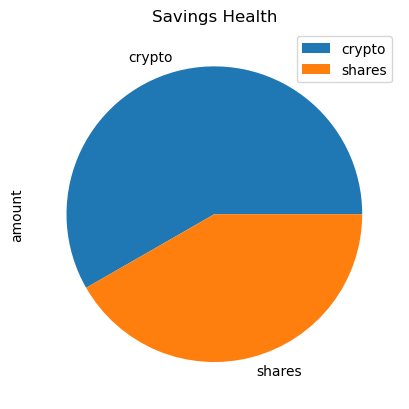

In [12]:
# Plot savings pie chart
df_savings.plot.pie(y='amount', title="Savings Health");

In [13]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
savings = df_savings['amount'].sum()
# Validate saving health
if df_savings['amount'].sum() > emergency_fund:
    print(f"Congratulation your savings are higher than your goal by {round(df_savings['amount'].sum()-emergency_fund,2)}")
elif df_savings['amount'].sum()==emergency_fund:
    print(f"Congratulation you have met your goal savings")
else:
    print(f"NEED TO SAVE MORE MONEY CURRENTLY {round(df_savings['amount'].sum()-emergency_fund,2)} much away from target")

Congratulation your savings are higher than your goal by 60340.2


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date_5y = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date_5y = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [15]:
# Get 5 years' worth of historical data for SPY and AGG
ticker_data_5y = api.get_bars(tickers,
                           timeframe,
                           start= start_date_5y,
                           end= end_date_5y).df
# Reorganize the DataFrame
# Separate ticker data
AGG_5y = ticker_data_5y[ticker_data_5y["symbol"]=="AGG"].drop("symbol", axis=1)
SPY_5y = ticker_data_5y[ticker_data_5y["symbol"]=="SPY"].drop("symbol", axis=1)



# Concatenate the ticker DataFrames
df_new_5y = pd.concat([AGG_5y,SPY_5y], axis=1, keys=['AGG','SPY'])

# Preview DataFrame
df_new_5y.sample(10)

AGG                                     \
                             open     high     low   close    volume   
timestamp                                                              
2017-08-01 04:00:00+00:00  109.38  109.720  109.36  109.72   2338876   
2017-01-25 05:00:00+00:00  107.98  108.040  107.83  107.92   2912944   
2016-12-06 05:00:00+00:00  108.14  108.180  108.04  108.09   3306875   
2016-08-17 04:00:00+00:00  112.45  112.660  112.36  112.57   5210636   
2018-07-19 04:00:00+00:00  106.34  106.545  106.31  106.48   2163268   
2017-06-15 04:00:00+00:00  109.90  109.900  109.78  109.87   2233855   
2020-09-04 04:00:00+00:00  118.41  118.520  118.08  118.10   5366819   
2018-01-02 05:00:00+00:00  109.26  109.310  108.97  109.16  14551510   
2016-12-27 05:00:00+00:00  107.19  107.340  107.19  107.34   2661574   
2020-10-08 04:00:00+00:00  117.67  117.710  117.59  117.69   4235989   

                                                      SPY                     \
                          trade_count        vwap    open      high      low   
timestamp                                                                      
2017-08-01 04:00:00+00:00       10476  109.649411  247.46  247.5000  246.716   
2017-01-25 05:00:00+00:00       11123  107.905325  228.70  229.5700  228.510   
2016-12-06 05:00:00+00:00       11571  108.092182  221.22  221.7441  220.662   
2016-08-17 04:00:00+00:00       16330  112.515475  218.00  218.5300  217.020   
2018-07-19 04:00:00+00:00       10957  106.448966  280.31  280.7400  279.460   
2017-06-15 04:00:00+00:00        8434  109.856463  242.68  243.9100  242.360   
2020-09-04 04:00:00+00:00       17987  118.203648  346.13  347.8300  334.870   
2018-01-02 05:00:00+00:00       18935  109.134443  267.84  268.8100  267.400   
2016-12-27 05:00:00+00:00       12051  107.272932  226.02  226.7300  226.000   
2020-10-08 04:00:00+00:00       17887  117.671642  342.85  343.8500  341.860   

                                                                        
                              close     volume trade_count        vwap  
timestamp                                                               
2017-08-01 04:00:00+00:00  247.3000   55050401      151132  247.199252  
2017-01-25 05:00:00+00:00  229.5500   84437898      246389  229.097514  
2016-12-06 05:00:00+00:00  221.6600   59877377      208254  221.263883  
2016-08-17 04:00:00+00:00  218.3700   75086839      269025  217.876488  
2018-07-19 04:00:00+00:00  279.9600   61491867      236049  280.146764  
2017-06-15 04:00:00+00:00  243.7697   66464888      255022  243.318560  
2020-09-04 04:00:00+00:00  342.3500  139181102      795605  341.744308  
2018-01-02 05:00:00+00:00  268.7700   87130750      233353  268.228135  
2016-12-27 05:00:00+00:00  226.2500   42672487      139273  226.325948  
2020-10-08 04:00:00+00:00  343.6500   45242621      290068  343.196083

In [16]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30_return = MCSimulation(portfolio_data=df_new_5y,weights=[.4,.6],num_simulation=500,num_trading_days=252*30)

                            
                    

In [17]:
# Printing the simulation input data
MC_30_return.portfolio_data.head()

AGG                                        \
                             open      high       low    close   volume   
timestamp                                                                 
2016-05-02 04:00:00+00:00  110.74  110.7400  110.5200  110.605  3553939   
2016-05-03 04:00:00+00:00  110.89  110.9450  110.7500  110.810  3044940   
2016-05-04 04:00:00+00:00  110.91  110.9315  110.7595  110.860  2920608   
2016-05-05 04:00:00+00:00  110.92  111.1600  110.8010  111.140  3008142   
2016-05-06 04:00:00+00:00  111.12  111.1200  110.9700  110.970  2718710   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2016-05-02 04:00:00+00:00       15119  110.627199          NaN  206.92   
2016-05-03 04:00:00+00:00       15662  110.865995     0.001853  206.52   
2016-05-04 04:00:00+00:00       13982  110.879063     0.000451  204.99   
2016-05-05 04:00:00+00:00       15707  111.028363     0.002526  205.56   
2016-05-06 04:00:00+00:00       12697  111.031967    -0.001530  204.08   

                                                                            \
                             high     low     close     volume trade_count   
timestamp                                                                    
2016-05-02 04:00:00+00:00  208.18  206.41  207.9700   61908515      263580   
2016-05-03 04:00:00+00:00  206.80  205.28  206.1592  106422142      377518   
2016-05-04 04:00:00+00:00  205.85  204.42  205.0100   92199810      345261   
2016-05-05 04:00:00+00:00  205.98  204.47  204.9700   67597222      280622   
2016-05-06 04:00:00+00:00  205.77  203.88  205.7200   89131004      340335   

                                                    
                                 vwap daily_return  
timestamp                                           
2016-05-02 04:00:00+00:00  207.294812          NaN  
2016-05-03 04:00:00+00:00  206.312060    -0.008707  
2016-05-04 04:00:00+00:00  205.090172    -0.005574  
2016-05-05 04:00:00+00:00  205.141555    -0.000195  
2016-05-06 04:00:00+00:00  204.937074     0.003659

In [18]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30_return.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 110.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 120.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 130.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 140.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 150.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 160.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 170.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 180.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 190.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 200.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 210.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 220.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 230.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 240.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 250.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 260.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 270.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 280.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 290.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 300.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 310.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 320.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 330.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 340.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 350.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 360.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 370.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 380.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 390.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 400.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 410.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 420.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 430.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 440.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 450.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 460.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 470.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 480.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 490.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.982264,1.006960,1.005080,0.999113,1.010490,0.997452,0.997180,0.983294,0.998750,1.006259,...,0.978835,0.993092,1.008305,0.993415,0.999459,0.994995,0.988114,1.009416,0.991612,0.992158
2,0.985813,1.019570,1.002627,0.997216,1.013945,0.998939,1.010873,0.976544,1.010000,1.005122,...,0.983269,1.006272,1.004534,0.999312,1.004126,1.000617,1.004952,1.018561,0.999309,0.987048
3,0.980988,1.018833,0.991802,1.014867,1.018342,0.993360,1.006172,0.974281,1.015053,1.000477,...,0.997173,1.021696,0.997191,0.996341,1.004782,0.999076,1.005538,1.017957,0.995487,0.983161
4,0.984990,1.016304,0.978429,1.020686,1.033858,0.983754,1.006177,0.968618,1.022412,0.997187,...,0.999493,1.022667,0.999438,1.005789,1.008469,0.997296,1.003092,1.015378,1.015624,0.978324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,3.033083,13.168487,27.425623,10.362538,7.134303,9.109141,15.684104,38.307243,10.919055,11.217883,...,7.351485,68.146078,11.986770,6.481276,25.610784,17.823385,18.012997,5.470211,8.197778,31.002822
7557,2.994661,13.234542,27.071959,10.443467,7.096825,9.225386,15.845841,38.225865,10.982672,11.152294,...,7.461156,68.110238,11.952320,6.499094,25.379587,17.577669,17.818698,5.465973,8.162464,31.058732
7558,3.013378,13.285847,27.062912,10.458368,7.222701,9.235382,15.789636,37.728663,10.870743,11.135526,...,7.369258,68.241346,11.766312,6.425250,25.415553,17.520014,17.918806,5.481191,8.188617,31.036765
7559,3.000209,13.218837,27.296191,10.458871,7.184654,9.404989,15.708215,38.172121,10.876962,11.208191,...,7.261503,68.075501,11.651241,6.449542,25.391920,17.545292,17.750177,5.515562,8.237172,31.056893


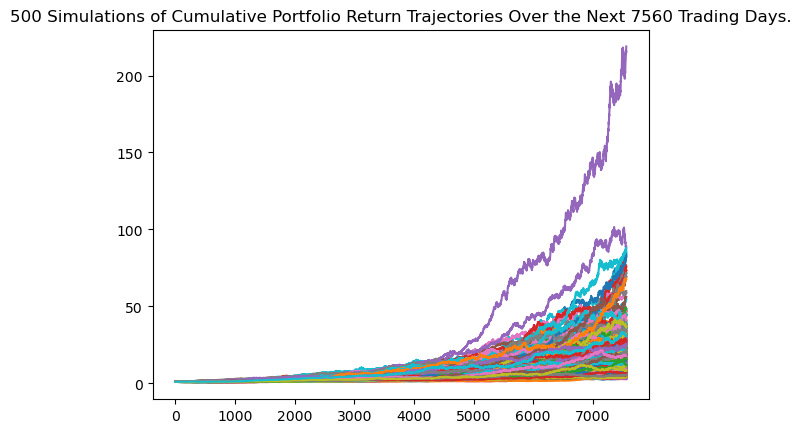

In [19]:
# Plot simulation outcomes
MC_30_return.plot_simulation();

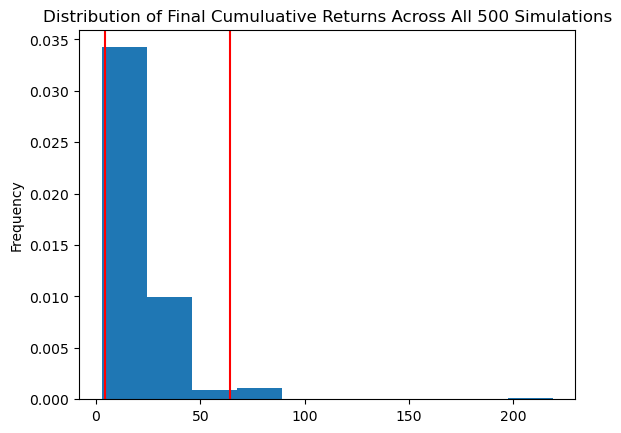

In [20]:
# Plot probability distribution and confidence intervals
MC_30_return.plot_distribution();

### Retirement Analysis

In [21]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_30_return.summarize_cumulative_return()

# Print summary statistics
tbl

count           500.000000
mean             19.877322
std              16.516608
min               2.703243
25%              10.475294
50%              15.519487
75%              24.830914
max             218.858602
95% CI Lower      4.480774
95% CI Upper     64.100323
Name: 7560, dtype: float64

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [22]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $89615.48 and $1282006.45


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [23]:
# Set initial investment
initial_investment_2 = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tbl[8]*initial_investment_2,2)
ci_upper = round(tbl[9]*initial_investment_2,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_2} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $134423.23 and $1923009.68


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [24]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_return = MCSimulation(portfolio_data=df_new_5y,weights=[.4,.6],num_simulation=500,num_trading_days=252*5)

     

In [25]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_return.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Monte Carlo simulation number 340.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 350.
Running Monte Carlo simulation number 360.
Running Monte Carlo simulation number 370.
Running Monte Carlo simulation number 380.
Running Monte Carlo simulation number 390.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 400.
Running Monte Carlo simulation number 410.
Running Monte Carlo simulation number 420.
Running Monte Carlo simulation number 430.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 440.
Running Monte Carlo simulation number 450.
Running Monte Carlo simulation number 460.
Running Monte Carlo simulation number 470.
Running Monte Carlo simulation number 480.
Running Monte Carlo simulation number 490.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.993973,1.000331,1.005667,1.005664,0.995837,1.010293,0.992749,0.990590,0.983666,0.994809,...,0.992091,1.002260,0.993950,1.001704,0.978870,0.999360,1.008806,1.001540,1.006004,1.010241
2,0.991564,1.022103,1.009042,1.013167,0.997665,1.010021,0.978360,0.987818,0.977840,1.008003,...,0.985821,1.015217,0.997055,1.008711,0.982707,1.002525,1.012139,1.000805,0.994095,1.003727
3,0.987230,1.021351,1.016532,0.997667,1.014184,1.017167,0.987265,0.991167,0.980079,1.018149,...,0.976638,1.016256,0.996590,1.011830,0.967701,0.989199,1.003644,1.001125,0.997121,0.995187
4,0.988009,1.013115,1.016468,0.988317,1.007697,1.011046,0.973020,0.990372,0.981850,1.014513,...,0.975635,1.013802,1.007324,1.006229,0.962570,0.989536,0.981780,1.000214,0.995796,0.990561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2.185989,1.316037,1.606031,1.731175,1.071930,1.652364,1.363258,1.067816,1.343117,1.457762,...,1.581227,1.423037,2.234050,2.382914,1.408602,1.340537,2.565593,1.109336,1.149962,1.861941
1257,2.173515,1.283696,1.596562,1.726572,1.060068,1.671948,1.372807,1.076786,1.331309,1.458577,...,1.574518,1.430978,2.238172,2.351539,1.406389,1.334283,2.581514,1.118973,1.151218,1.869548
1258,2.157136,1.296826,1.603009,1.731155,1.070883,1.692793,1.356939,1.089254,1.351954,1.458426,...,1.594979,1.430890,2.242069,2.349003,1.404467,1.331236,2.559111,1.120336,1.156275,1.880678
1259,2.162715,1.291517,1.602881,1.713598,1.063892,1.679404,1.351849,1.091116,1.359738,1.460194,...,1.596048,1.432575,2.257136,2.348905,1.401256,1.332628,2.529084,1.120792,1.152272,1.891920


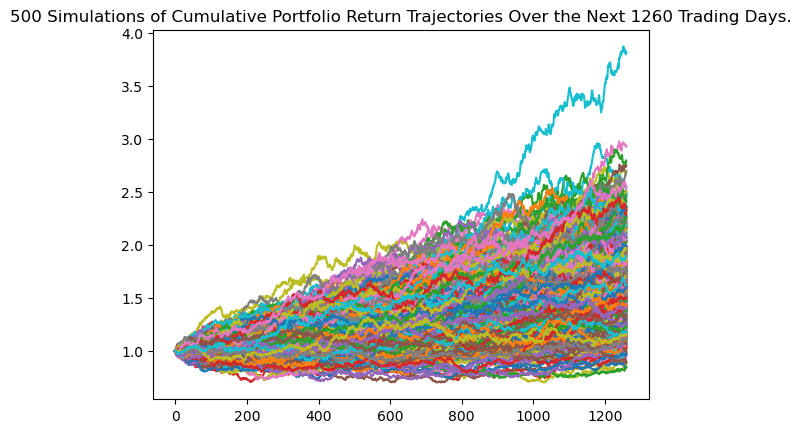

In [26]:
# Plot simulation outcomes
MC_5_return.plot_simulation();

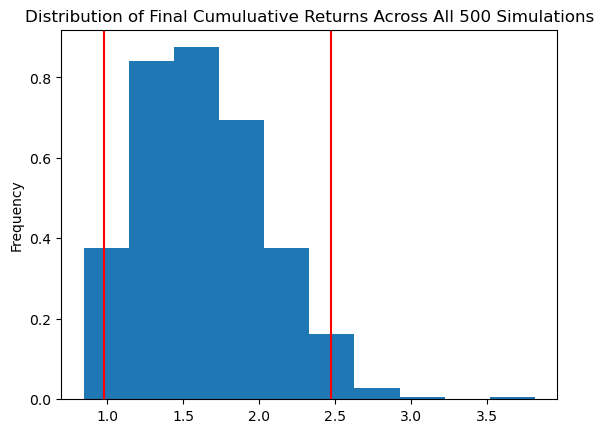

In [27]:
# Plot probability distribution and confidence intervals
MC_5_return.plot_distribution();

In [28]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_5 = MC_5_return.summarize_cumulative_return()
# Print summary statistics
tbl_5

count           500.000000
mean              1.637627
std               0.413728
min               0.845975
25%               1.339868
50%               1.598202
75%               1.907667
max               3.817785
95% CI Lower      0.976640
95% CI Upper      2.474047
Name: 1260, dtype: float64

In [29]:
# Set initial investment
initial_investment_5y = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower_five = round(tbl_5[8]*initial_investment_5y,2)
ci_upper_five = round(tbl_5[9]*initial_investment_5y,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_5y} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $19532.81 and $49480.93


### Ten Years Retirement Option

In [30]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10_return = MCSimulation(portfolio_data=df_new_5y,weights=[.4,.6],num_simulation=500,num_trading_days=252*10)


In [31]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10_return.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 340.
Running Monte Carlo simulation number 350.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 360.
Running Monte Carlo simulation number 370.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 380.
Running Monte Carlo simulation number 390.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 400.
Running Monte Carlo simulation number 410.
Running Monte Carlo simulation number 420.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 430.
Running Monte Carlo simulation number 440.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 450.
Running Monte Carlo simulation number 460.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 470.
Running Monte Carlo simulation number 480.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

Running Monte Carlo simulation number 490.


/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/naz/Desktop/FinTech/Module_Challenges/Fintech_consulting_CTO/Starter_Code/MCForecastTools.p

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000871,0.999289,0.996817,0.997060,1.008049,1.012847,1.001277,1.000844,0.996644,0.999181,...,1.005207,0.993372,1.000215,1.004943,0.988831,1.003418,0.995125,1.000729,0.995856,1.001108
2,0.988075,0.988858,1.002566,0.986249,1.010821,1.016874,1.005239,0.987081,1.005826,0.999342,...,1.000233,1.006633,1.011024,0.994481,0.991002,1.007966,0.995770,1.001612,0.993209,0.999492
3,0.982248,0.994892,1.006401,0.997880,1.010691,1.017187,1.011901,0.982961,1.011619,0.994503,...,0.989249,1.006775,1.014956,0.994951,0.994783,1.008307,0.987098,0.988666,1.005013,1.000541
4,0.980512,0.990109,1.005648,1.001774,1.010583,1.018290,1.003367,0.979040,1.017490,0.989478,...,0.987755,1.009039,1.024499,0.999038,0.998798,1.018077,0.981057,0.987860,1.003920,1.014053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,0.994789,3.012840,3.010640,2.939820,1.357858,1.908686,2.192709,2.627619,4.166349,2.587045,...,2.812341,3.711052,1.506268,1.532482,3.054549,1.433683,1.088203,1.614532,2.286427,1.508279
2517,0.989119,3.015377,2.963382,2.923812,1.365438,1.912850,2.183330,2.588756,4.173542,2.572732,...,2.818983,3.750773,1.506273,1.540176,3.064808,1.437832,1.079925,1.643302,2.275170,1.513424
2518,0.988054,2.990919,2.961016,2.957969,1.357052,1.910241,2.177612,2.554018,4.179853,2.560735,...,2.801676,3.736194,1.508630,1.528208,3.065267,1.426300,1.090756,1.633520,2.289184,1.527657
2519,0.975425,2.958925,3.005965,2.986264,1.356428,1.919119,2.185141,2.560608,4.213035,2.537585,...,2.810818,3.711668,1.502401,1.530599,3.044979,1.424913,1.082404,1.633935,2.284684,1.532507


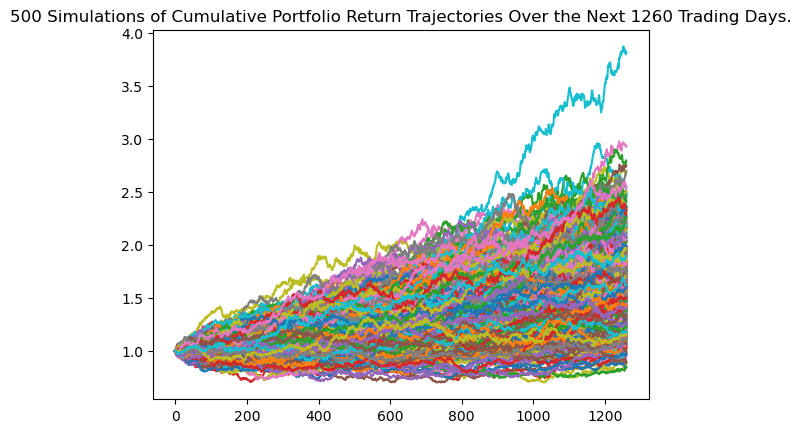

In [32]:
# Plot simulation outcomes
MC_5_return.plot_simulation();

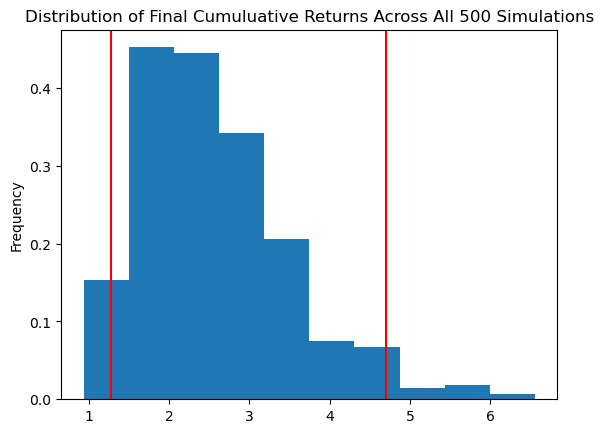

In [33]:
# Plot probability distribution and confidence intervals
MC_10_return.plot_distribution();

In [34]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_10 = MC_5_return.summarize_cumulative_return()
# Print summary statistics
tbl_10

count           500.000000
mean              1.637627
std               0.413728
min               0.845975
25%               1.339868
50%               1.598202
75%               1.907667
max               3.817785
95% CI Lower      0.976640
95% CI Upper      2.474047
Name: 1260, dtype: float64

In [35]:
# Set initial investment
initial_investment_10y = 20000


# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower_ten = round(tbl_10[8]*initial_investment_10y,2)
ci_upper_ten = round(tbl_10[9]*initial_investment_10y,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_10y} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 10 years will end within in the range of $19532.81 and $49480.93
